In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_ind
from sqlalchemy import create_engine
from scipy.stats.mstats import winsorize
from scipy.stats import boxcox
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from wordcloud import WordCloud
import statsmodels.api as sm

import warnings

%matplotlib inline
sns.set()

warnings.filterwarnings('ignore')

## First, load the dataset from the weatherinszeged table from Thinkful's database.

In [35]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
weather_df = pd.read_sql_query('select * from weatherinszeged',con=engine)

engine.dispose()

In [36]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
date                   96453 non-null datetime64[ns, UTC]
summary                96453 non-null object
preciptype             96453 non-null object
temperature            96453 non-null float64
apparenttemperature    96453 non-null float64
humidity               96453 non-null float64
windspeed              96453 non-null float64
windbearing            96453 non-null float64
visibility             96453 non-null float64
loudcover              96453 non-null float64
pressure               96453 non-null float64
dailysummary           96453 non-null object
dtypes: datetime64[ns, UTC](1), float64(8), object(3)
memory usage: 8.8+ MB


## Build a linear regression model where your target variable is the difference between the apparenttemperature and the temperature. As explanatory variables, use humidity and windspeed. Now, estimate your model using OLS. Are the estimated coefficients statistically significant? Are the signs of the estimated coefficients in line with your previous expectations? Interpret the estimated coefficients. What are the relations between the target and the explanatory variables?

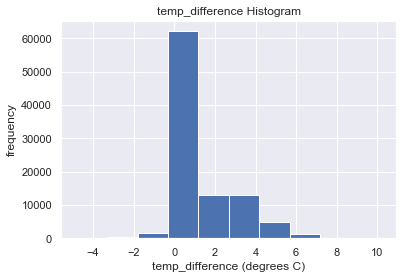

In [50]:
#examine target variable

weather_df['temp_difference'] = weather_df.temperature - weather_df.apparenttemperature

plt.hist(weather_df.temp_difference)
plt.title("temp_difference Histogram")
plt.xlabel("temp_difference (degrees C)")
plt.ylabel("frequency")
plt.show()

In [49]:
# Y is the target variable
Y = weather_df['temp_difference']

# X is the feature set
X = weather_df[['humidity','windspeed']]

# We add a constant to the model
X = sm.add_constant(X)

# We fit an OLS model using statsmodels
results = sm.OLS(Y, X).fit()

# We print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        temp_difference   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                 1.949e+04
Date:                Mon, 22 Jul 2019   Prob (F-statistic):               0.00
Time:                        18:33:56   Log-Likelihood:            -1.7046e+05
No. Observations:               96453   AIC:                         3.409e+05
Df Residuals:                   96450   BIC:                         3.409e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.4381      0.021   -115.948      0.0

The summary results indicate that the estimated coefficients are statistically significant! The target variable is _actual temperature less apparent temperature_, therefore it is reasonable to expect that an increase in humdity or windspeed would result in an increase of the target.  In other words, as either feature increases, the target increases, and so the signs of the coefficients in the model are in line with what we should expect. In plain English: we expect that it feels colder when there is more humidity or higher wind speed, and this is what the model predicts.  More specifically, as the humidity increases by 1 percent, the target increases by ~3 degrees C; and as the windspeed increases by 1 km/h, the target increases by ~1e-1 degrees C.

## Check if your model meets the Gauss-Markov Conditions above. If some of the assumptions are not met, discuss the implications of the violations for the correctness of your model.

## Next, include the interaction of humidity and windspeed to the model above and estimate the model using OLS. Are the coefficients statistically significant? Did the signs of the estimated coefficients for humidity and windspeed change? Interpret the estimated coefficients.

In [51]:
weather_df['humidity_times_windspeed'] = weather_df.humidity * weather_df.windspeed

# Y is the target variable
Y = weather_df['temp_difference']

# X is the feature set
X = weather_df[['humidity','windspeed','humidity_times_windspeed']]

# We add a constant to the model
X = sm.add_constant(X)

# We fit an OLS model using statsmodels
results = sm.OLS(Y, X).fit()

# We print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        temp_difference   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.341
Method:                 Least Squares   F-statistic:                 1.666e+04
Date:                Mon, 22 Jul 2019   Prob (F-statistic):               0.00
Time:                        19:01:52   Log-Likelihood:            -1.6669e+05
No. Observations:               96453   AIC:                         3.334e+05
Df Residuals:                   96449   BIC:                         3.334e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

The coefficients of the model are statistically significant. The signs of the estimated coefficients for windspeed and humidity reversed wrt the previous model.  This is because of the multiplicative effect of the new feature, which for every unit increase raises the target by ~0.3 degrees C, while a unit increase in windspeed or humidity lowers the target by ~0.17 or ~0.09 degrees C, respectively. Although the new feature's coefficient is similar in magnitude to the other two feature's coefficients, its effect on the target should be greater across most of the relevant domains because of the multiplicative interaction.  